In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [7]:
# Load the data
signdata = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/signdata.csv', encoding='latin-1')

# Make a copy of the data
processed_data = signdata.copy()

# Preprocessing for numerical features
numerical_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Drop specific columns
columns_to_drop = [
    'UlnarRotationM4.2.0', 'FlexionChangeM5.2.0', 'SpreadChangeM5.2.0',
    'SignTypeM5.2.0', 'MovementM5.2.0', 'RepeatedMovementM5.2.0',
    'MajorLocationM5.2.0', 'MinorLocationM5.2.0', 'SecondMinorLocationM5.2.0',
    'ContactM5.2.0', 'NonDominantHandshapeM5.2.0', 'UlnarRotationM5.2.0',
    'FlexionChangeM6.2.0', 'SpreadChangeM6.2.0', 'SignTypeM6.2.0',
    'MovementM6.2.0', 'RepeatedMovementM6.2.0', 'MajorLocationM6.2.0',
    'MinorLocationM6.2.0', 'SecondMinorLocationM6.2.0', 'ContactM6.2.0',
    'NonDominantHandshapeM6.2.0', 'UlnarRotationM6.2.0'
]

processed_data.drop(columns=columns_to_drop, inplace=True)

# Verify that remaining columns have names
if any(processed_data.columns.isnull()):
    # Explicitly assign column names if necessary
    processed_data.columns = [f'Column_{i}' for i in range(len(processed_data.columns))]

# Separate numerical and categorical columns
numerical_cols = processed_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = processed_data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical features
imputer = SimpleImputer(strategy='median')
processed_data[numerical_cols] = scaler.fit_transform(imputer.fit_transform(processed_data[numerical_cols]))

# Handle missing values for categorical columns
for col in categorical_cols:
    processed_data[col].fillna(processed_data[col].mode()[0], inplace=True)

# Use OrdinalEncoder for categorical columns
ordinal_encoder = OrdinalEncoder()
for col in categorical_cols:
    processed_data[[col]] = ordinal_encoder.fit_transform(processed_data[[col]])

# Replace '.' with '_' in column names
processed_data.columns = processed_data.columns.str.replace('.', '_')

# Save the processed data to a new CSV file
processed_data.to_csv('/Users/emilkoch/Desktop/2Tango/Data Files/processed_signdata.csv', index=False)

# Verify if processed_data contains column names for all columns
contains_column_names = all(isinstance(col, str) for col in processed_data.columns)

if contains_column_names:
    print("processed_data contains column names for all columns.")
else:
    print("processed_data does not contain column names for all columns.")

/var/folders/4r/5qs7726s3_dc54vtgh1sc2740000gn/T/ipykernel_50588/2135766831.py:48: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_data.columns = processed_data.columns.str.replace('.', '_')


processed_data contains column names for all columns.


In [21]:
X = processed_data.drop('SignBankEnglishTranslations', axis=1)
y = processed_data['SignBankEnglishTranslations']

In [22]:
# Exclude 'SignBankEnglishTranslations' from categorical_cols
categorical_cols.remove('SignBankEnglishTranslations')

# Combine the ordinal encoded categorical features and the target variable into a single DataFrame
data_for_chi2 = pd.concat([processed_data[categorical_cols], y], axis=1)

# Initialize an empty dictionary to store chi-square statistics and p-values
chi2_results = {}

# Perform the chi-square test for each categorical feature
for col in categorical_cols:
    contingency_table = pd.crosstab(data_for_chi2[col], y)
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = {'Chi2 Statistic': chi2_stat, 'P-Value': p_value}

# Print the results
print("Chi-square test results for each categorical feature:")
for col, result in chi2_results.items():
    print(f"{col}: Chi2 Statistic = {result['Chi2 Statistic']}, P-Value = {result['P-Value']}")

Chi-square test results for each categorical feature:
EntryID: Chi2 Statistic = 4902077.085127864, P-Value = 0.0877268974854163
LemmaID: Chi2 Statistic = 4846694.148160615, P-Value = 5.153424290217726e-58
Code: Chi2 Statistic = 4906846.000000007, P-Value = 0.28248533591389047
Batch: Chi2 Statistic = 17407.04112363619, P-Value = 5.555111810816072e-11
DominantTranslation: Chi2 Statistic = 920493.0468828698, P-Value = 1.0
NondominantTranslations: Chi2 Statistic = 779752.0304624784, P-Value = 1.0
Iconicity_ID: Chi2 Statistic = 711312.3654361363, P-Value = 1.0
IconicityType: Chi2 Statistic = 6282.357413930966, P-Value = 5.386189044599345e-16
LexicalClass: Chi2 Statistic = 13454.485367243431, P-Value = 7.865913426555138e-63
Handshape.2.0: Chi2 Statistic = 98615.06096145467, P-Value = 1.0
SelectedFingers.2.0: Chi2 Statistic = 20502.5662064485, P-Value = 0.0003584136701429253
Flexion.2.0: Chi2 Statistic = 10989.599970155425, P-Value = 0.11396251428407381
ThumbPosition.2.0: Chi2 Statistic = 193

In [14]:
# Choose significance level (alpha)
alpha = 0.05

# Initialize a list to store statistically significant features
significant_features = []

# Filter features based on p-values
for col, result in chi2_results.items():
    if result['P-Value'] < alpha:
        significant_features.append(col)

# Print statistically significant features
print("Statistically significant features based on the chi-square test:")
print(significant_features)

Statistically significant features based on the chi-square test:
['LemmaID', 'Batch', 'IconicityType', 'LexicalClass', 'SelectedFingers.2.0', 'ThumbPosition.2.0', 'SignType.2.0', 'Movement.2.0', 'MajorLocation.2.0', 'MinorLocation.2.0', 'SignTypeM4.2.0', 'MovementM4.2.0', 'MajorLocationM4.2.0', 'MinorLocationM4.2.0', 'ThumbPositionM6.2.0', 'SignBankAnnotationID', 'SignBankLemmaID', 'SignBankSemanticField', 'InCDI', 'CDISemanticCategory']


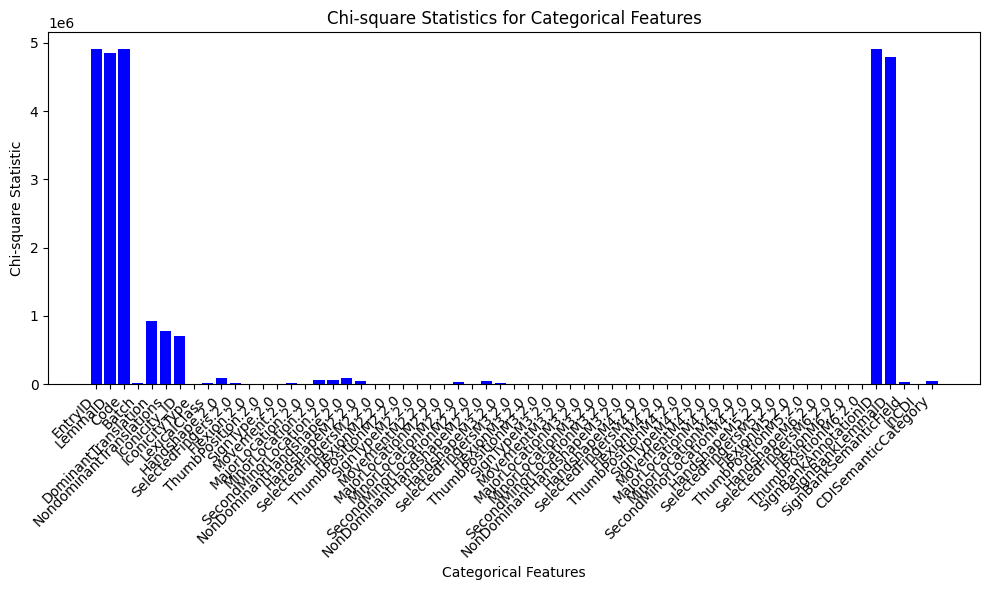

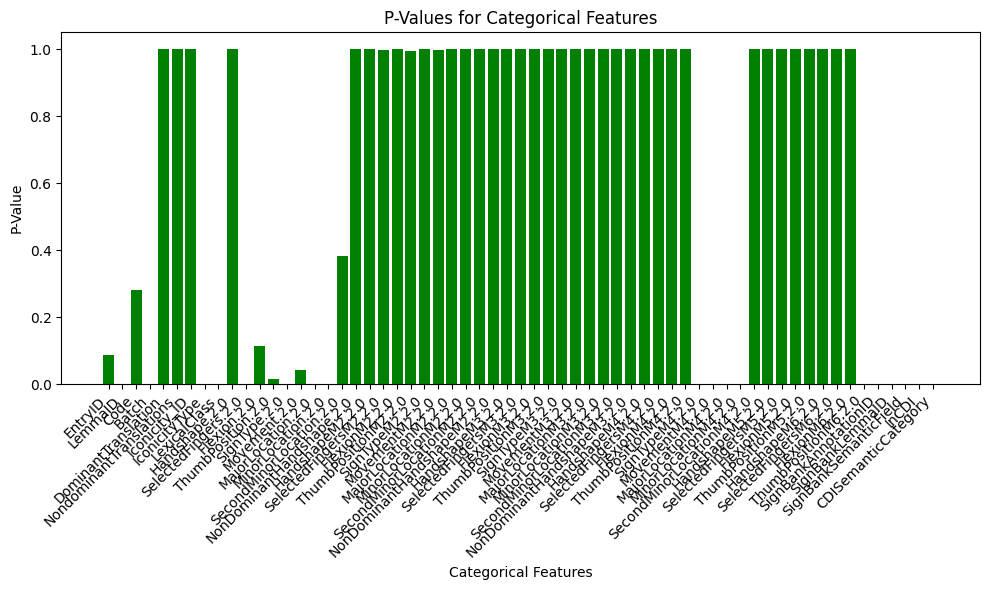

In [23]:
# Extract chi-square statistics and p-values from chi2_results
chi2_stats = [result['Chi2 Statistic'] for result in chi2_results.values()]
p_values = [result['P-Value'] for result in chi2_results.values()]

# Plot chi-square statistics
plt.figure(figsize=(10, 6))
plt.bar(categorical_cols, chi2_stats, color='blue')
plt.xlabel('Categorical Features')
plt.ylabel('Chi-square Statistic')
plt.title('Chi-square Statistics for Categorical Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot p-values
plt.figure(figsize=(10, 6))
plt.bar(categorical_cols, p_values, color='green')
plt.xlabel('Categorical Features')
plt.ylabel('P-Value')
plt.title('P-Values for Categorical Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Iterate over each numerical feature in X
for column in numerical_cols:
    # Group the numerical feature by categories of the target variable
    groups = [X[column][y == category] for category in np.unique(y)]
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*groups)
    # Print the results
    print(f"{column}: F-Statistic = {f_statistic}, P-Value = {p_value}")

List: F-Statistic = 0.9782942433083566, P-Value = 0.6515536345935642
Item: F-Statistic = 0.7966544532512869, P-Value = 0.9999706356313942
EnglishWF(lg10): F-Statistic = 1.227514296692374, P-Value = 0.00020894803533577435
SignFrequency(M): F-Statistic = 1.190569533860824, P-Value = 0.0013187106192019003
SignFrequency(SD): F-Statistic = 0.8927004988636665, P-Value = 0.9771556303506993
SignFrequency(Z): F-Statistic = 1.1787544116350779, P-Value = 0.0022804826928035076
SignFrequency(N): F-Statistic = 0.8796004083298219, P-Value = 0.9880698533766472
Unknown: F-Statistic = 0.4901730452788644, P-Value = 0.9999999999999999
SignFrequency(M-Native): F-Statistic = 1.239699574754977, P-Value = 0.00010924595845076361
SignFrequency(SD-Native): F-Statistic = 0.7636877415474609, P-Value = 0.9999990911072719
SignFreq(Z-native): F-Statistic = 1.1702778818017097, P-Value = 0.0033346193749956127
SignFrequency(N-Native): F-Statistic = 1.207036305425391, P-Value = 0.0005940328476700859
Unknown(Native): F-St

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


SpreadChangeM3.2.0: F-Statistic = nan, P-Value = nan
ThumbContactM3.2.0: F-Statistic = 0.13221296112732478, P-Value = 0.9999999999999999
RepeatedMovementM3.2.0: F-Statistic = 0.0005003186411212167, P-Value = 0.9999999999999999
ContactM3.2.0: F-Statistic = 0.542984557172537, P-Value = 0.9999999999999999
UlnarRotationM3.2.0: F-Statistic = nan, P-Value = nan
MarkedHandshapeM4.2.0: F-Statistic = 0.17193695913426618, P-Value = 0.9999999999999999
FlexionChangeM4.2.0: F-Statistic = nan, P-Value = nan
SpreadM4.2.0: F-Statistic = 0.000500318641121217, P-Value = 0.9999999999999999
SpreadChangeM4.2.0: F-Statistic = nan, P-Value = nan
ThumbContactM4.2.0: F-Statistic = 0.30688662891996243, P-Value = 0.9999999999999999
RepeatedMovementM4.2.0: F-Statistic = nan, P-Value = nan
ContactM4.2.0: F-Statistic = inf, P-Value = 0.0
NonDominantHandshapeM4.2.0: F-Statistic = nan, P-Value = nan
MarkedHandshapeM5.2.0: F-Statistic = 0.000500318641121217, P-Value = 0.9999999999999999
SpreadM5.2.0: F-Statistic = nan

In [27]:
# Choose significance level (alpha)
alpha = 0.05

# Initialize a list to store statistically significant features
significant_numerical_features = []

# Filter features based on p-values from ANOVA
for column in numerical_cols:
    # Group the numerical feature by categories of the target variable
    groups = [X[column][y == category] for category in np.unique(y)]
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*groups)
    # Check if p-value is less than alpha
    if p_value < alpha:
        significant_numerical_features.append(column)

# Print statistically significant numerical features
print("Statistically significant numerical features based on ANOVA:")
print(significant_numerical_features)

Statistically significant numerical features based on ANOVA:
['EnglishWF(lg10)', 'SignFrequency(M)', 'SignFrequency(Z)', 'SignFrequency(M-Native)', 'SignFreq(Z-native)', 'SignFrequency(N-Native)', 'SignFrequency(N-Nonnative)', 'SignFreq(Z-Nonnative)', 'Iconicity(M)', 'Iconicity(SD)', 'Iconicity(Z)', 'Iconicity(N)', 'D.Iconicity(M)', 'D.Iconicity(SD)', 'D.Iconicity(N)', 'D.Iconicity(Z)', 'D.Iconicity(M-native)', 'D.Iconicity(SD-native)', 'D.Iconicity(Z-native)', 'D.Iconicity(N-native)', 'GuessConsistency', 'GuessAccuracy', 'Transparency(M)', 'Transparency SD', 'Transparency Z', 'Initialized.2.0', 'Compound.2.0', 'SignOnset(ms)', 'ClipDuration(ms)', 'MarkedHandshape.2.0', 'FlexionChange.2.0', 'Spread.2.0', 'ThumbContact.2.0', 'RepeatedMovement.2.0', 'Contact.2.0', 'UlnarRotation.2.0', 'MarkedHandshapeM2.2.0', 'SpreadM2.2.0', 'UlnarRotationM2.2.0', 'ContactM4.2.0', 'SignType.2.0Frequency', 'MajorLocation.2.0Frequency', 'MinorLocation.2.0Frequency', 'SecondMinorLocation.2.0Frequency', 'Mov

In [28]:
# List of columns to include
selected_columns = [
    'LemmaID', 'Batch', 'IconicityType', 'LexicalClass', 'SelectedFingers.2.0', 'ThumbPosition.2.0', 'SignType.2.0',
    'Movement.2.0', 'MajorLocation.2.0', 'MinorLocation.2.0', 'SignTypeM4.2.0', 'MovementM4.2.0', 'MajorLocationM4.2.0',
    'MinorLocationM4.2.0', 'ThumbPositionM6.2.0', 'SignBankAnnotationID', 'SignBankLemmaID', 'SignBankSemanticField',
    'InCDI', 'CDISemanticCategory', 'EnglishWF(lg10)', 'SignFrequency(M)', 'SignFrequency(Z)', 'SignFrequency(M-Native)',
    'SignFreq(Z-native)', 'SignFrequency(N-Native)', 'SignFrequency(N-Nonnative)', 'SignFreq(Z-Nonnative)', 'Iconicity(M)',
    'Iconicity(SD)', 'Iconicity(Z)', 'Iconicity(N)', 'D.Iconicity(M)', 'D.Iconicity(SD)', 'D.Iconicity(N)', 'D.Iconicity(Z)',
    'D.Iconicity(M-native)', 'D.Iconicity(SD-native)', 'D.Iconicity(Z-native)', 'D.Iconicity(N-native)', 'GuessConsistency',
    'GuessAccuracy', 'Transparency(M)', 'Transparency SD', 'Transparency Z', 'Initialized.2.0', 'Compound.2.0',
    'SignOnset(ms)', 'ClipDuration(ms)', 'MarkedHandshape.2.0', 'FlexionChange.2.0', 'Spread.2.0', 'ThumbContact.2.0',
    'RepeatedMovement.2.0', 'Contact.2.0', 'UlnarRotation.2.0', 'MarkedHandshapeM2.2.0', 'SpreadM2.2.0',
    'UlnarRotationM2.2.0', 'ContactM4.2.0', 'SignType.2.0Frequency', 'MajorLocation.2.0Frequency',
    'MinorLocation.2.0Frequency', 'SecondMinorLocation.2.0Frequency', 'Movement.2.0Frequency',
    'SelectedFingers.2.0Frequency', 'Flexion.2.0Frequency', 'FlexionChange.2.0Frequency',
    'RepeatedMovement.2.0Frequency', 'Contact.2.0Frequency', 'Spread.2.0Frequency', 'SpreadChange.2.0Frequency',
    'ThumbContact.2.0Frequency', 'ThumbPosition.2.0Frequency', 'UlnarRotation.2.0Frequency',
    'Parameter.Neighborhood.Density.2.0', 'PhonotacticProbability', 'Phonological Complexity',
    'SignBankReferenceID', 'bglm_aoa', 'empirical_aoa'
]

# Filter X to include only the selected columns
filtered_X = X[selected_columns]

In [29]:
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_X, y, test_size=0.2, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy_rf)

# Print classification report
print(classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.29724770642201837
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         0
        17.0       0.00      0.00      0.00         0
        19.0       0.00      0.00      0.00         0
        20.0       0.00      0.00      0.00         1
        24.0       0.00      0.00      0.00         0
        26.0       0.00      0.00      0.00         1
        27.0       0.00      0.00      0.00         1
        34.0       0.00      0.00      0.00         1
        35.0       0.00      0.00      0.00         0
        36.0       0.00      0.00      0.00         1
        40.0       0.00      0.00      0.00         1
        43.0       0.00      0.00      0.00         1
        48.0       0.00      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

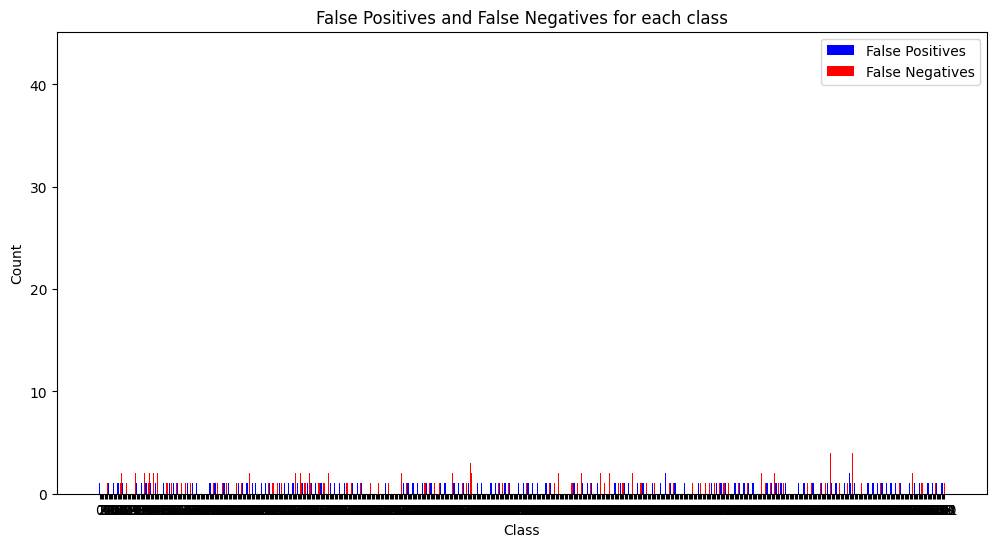

In [30]:
# Convert y_test and y_pred_rf to NumPy arrays
y_test_np = np.array(y_test)
y_pred_rf_np = np.array(y_pred_rf)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_rf_np)

# Calculate TP, TN, FP, FN for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=1) - TP
FN = np.sum(conf_matrix, axis=0) - TP

# Get the number of classes
num_classes = len(TP)

# Plot false positives and false negatives for each class
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(num_classes)
plt.bar(index, FP, bar_width, label='False Positives', color='b')
plt.bar(index + bar_width, FN, bar_width, label='False Negatives', color='r')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('False Positives and False Negatives for each class')
plt.xticks(index + bar_width / 2, range(num_classes))
plt.legend()
plt.show()

In [31]:
from imblearn.under_sampling import TomekLinks

# Instantiate TomekLinks
tomek_links = TomekLinks()

# Resample the data
X_resampled, y_resampled = tomek_links.fit_resample(filtered_X, y)

In [32]:
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy_rf)

# Print classification report
print(classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.39944903581267216
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1
        29.0       0.00      0.00      0.00         0
        38.0       0.00      0.00      0.00         1
        43.0       0.00      0.00      0.00         1
        45.0       0.00      0.00      0.00         1
        58.0       0.00      0.00      0.00         0
        61.0       0.00      0.00      0.00         0
        63.0       0.00      0.00      0.00         2
        65.0       0.00      0.00      0.00         0
        75.0       0.00      0.00      0.00         1
        77.0       0.00      0.00      0.00         1
        87.0       0.00      0.00      0.00         1
        89.0       0.00      0.00      0.00         0
        96.0       0.00      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Instantiate the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Test Accuracy:", accuracy_gb)

# Print classification report
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Test Accuracy: 0.31955922865013775
              precision    recall  f1-score   support

         7.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1
        26.0       0.00      0.00      0.00         0
        27.0       0.00      0.00      0.00         0
        38.0       0.00      0.00      0.00         1
        39.0       0.00      0.00      0.00         0
        43.0       0.00      0.00      0.00         1
        45.0       0.00      0.00      0.00         1
        55.0       0.00      0.00      0.00         0
        63.0       0.00      0.00      0.00         2
        64.0       0.00      0.00      0.00         0
        75.0       0.00      0.00      0.00         1
        77.0       0.00      0.00      0.00         1
        82.0       0.00     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn